In [1]:
!pip install networkx 

In [2]:
import networkx as nx

In [3]:
import matplotlib.pyplot as plt

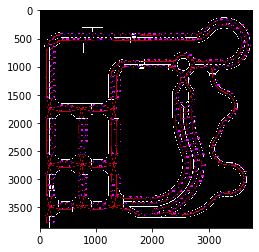

In [4]:
G = nx.read_graphml('comp_track.graphml')
import cv2
img=cv2.imread("Competition_track.png")
plt.imshow(img)

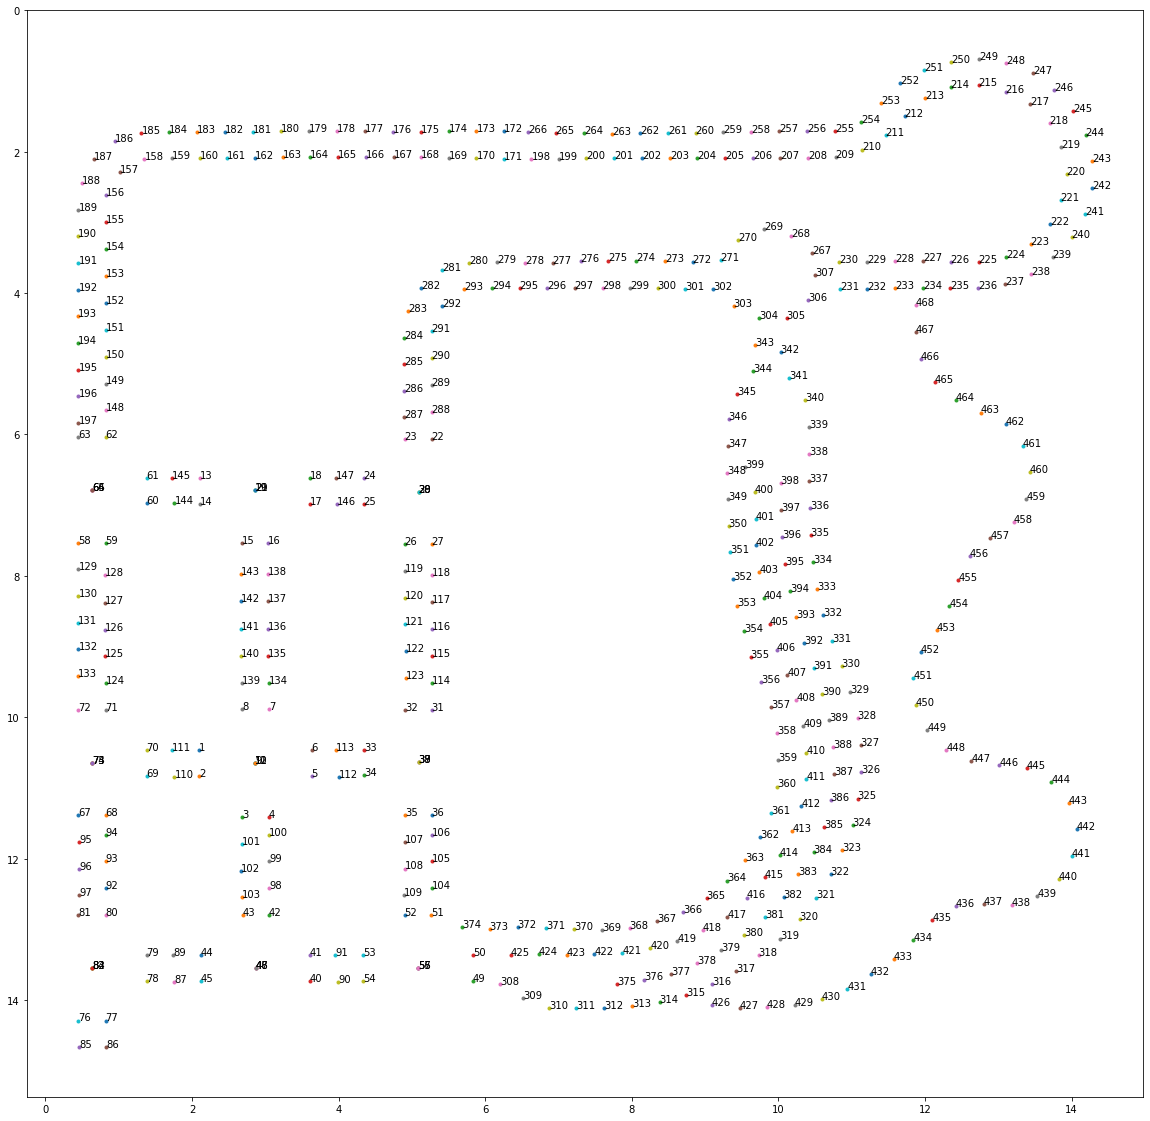

In [5]:
plt.figure(figsize=(20,20))
for node,data in G.nodes(data=True):
    plt.plot(data['x'],data['y'],'.')
    ax = plt.gca()
    ax.annotate(str(node), (data['x'],data['y'])) 

ax = plt.gca()
ax.invert_yaxis()
# plt.legend()
# plt.show()

In [6]:
for i in G.neighbors('24'):
    print(i)

147


In [7]:
import heapq
def dijkstra(G, start, target):
    d = {start: 0}
    parent = {start: None}
    pq = [(0, start)]
    visited = set()
    while pq:
        du, u = heapq.heappop(pq)
        if u in visited:
            continue
        if u == target:
            break
        visited.add(u)
        for v  in G.adj[u]:
            if v not in d or d[v] > du + 1:
                d[v] = du + 1
                parent[v] = u
                heapq.heappush(pq, (d[v], v))

    fp = [target]
    tg = target

    while tg != start:
        fp.insert(0, parent[tg])
        tg = parent[tg]

    return fp

In [8]:
path_list=dijkstra(G,'86','54')

In [9]:
G["86"]

AtlasView({'77': {'dotted': False}})

In [10]:
node_dict=G.nodes(data=True)

In [11]:
node_dict['86']

{'x': 0.83, 'y': 14.67}

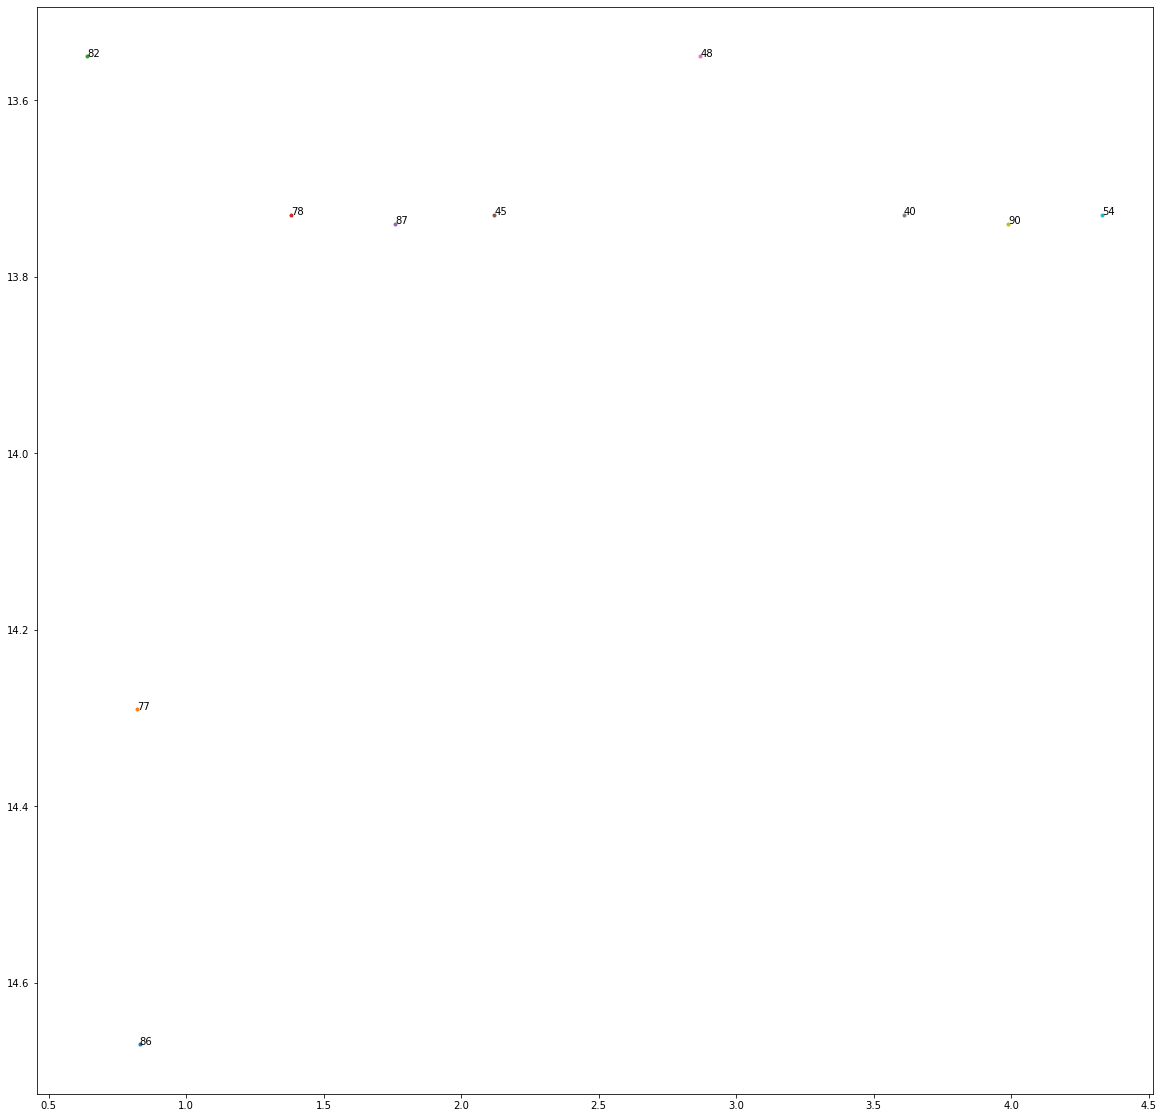

In [12]:
coord_list=[]
plt.figure(figsize=(20,20))
for i in path_list:
    data=node_dict[i]
    plt.plot(data['x'],data['y'],'.')
    coord_list.append((data['x'],data['y']))
    ax = plt.gca()
    ax.annotate(str(i), (data['x'],data['y'])) 

# plt.xlim(0,6)
# plt.ylim(0,6)


ax = plt.gca()
ax.invert_yaxis()

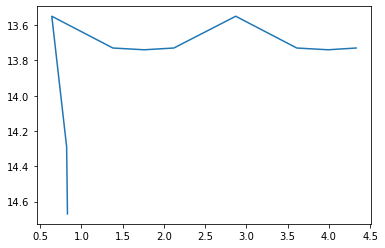

In [13]:
x, y = zip(*coord_list)
plt.plot(x,y)
ax = plt.gca()
ax.invert_yaxis()

In [14]:
def path_smooth(path, weight_data=0.5, weight_smooth=0.6, tolerance=0.000001):
    """
    Creates a smooth path for a n-dimensional series of coordinates.
    Arguments:
        path: List containing coordinates of a path
        weight_data: Float, how much weight to update the data (alpha)
        weight_smooth: Float, how much weight to smooth the coordinates (beta).
        tolerance: Float, how much change per iteration is necessary to keep iterating.
    Output:
        new: List containing smoothed coordinates.
    """

    new = deepcopy(path)
    dims = len(path[0])
    change = tolerance

    while change >= tolerance:
        change = 0.0
        for i in range(1, len(new) - 1):
            for j in range(dims):

                x_i = path[i][j]
                y_i, y_prev, y_next = new[i][j], new[i - 1][j], new[i + 1][j]

                y_i_saved = y_i
                y_i += weight_data * (x_i - y_i) + weight_smooth * (
                    y_next + y_prev - (2 * y_i)
                )
                new[i][j] = y_i

                change += abs(y_i - y_i_saved)

    return new

In [ ]:
path2 = path_smooth(coord_list)

In [19]:
class CarState:
    def __init__(self, v=14, dt=0.1, l=0.365) -> None:
        self.steering_angle = 0.0
        self.det_intersection = False
        self.x = 0
        self.y = 0
        self.yaw = 0
        self.tl = {}
        self.v = v
        self.dt = dt
        self.l = l

    def update_pos(self, steering_angle):
        self.x = self.x + self.v * math.cos(self.yaw) * self.dt
        self.y = self.y + self.v * math.sin(self.yaw) * self.dt
        self.yaw = self.yaw + self.v / self.l * math.tan(steering_angle) * self.dt  # steering_angle is the steering angle

    def update(
        self,
        angle: float,
        det_intersection: bool,
        x: float,
        y: float,
        yaw: float,
        tl: dict,
    ) -> None:
        self.steering_angle = angle
        self.det_intersection = det_intersection
        self.x = x
        self.y = y
        self.yaw = yaw
        self.tl = tl

In [18]:
class PurePursuit:
    def __init__(self, kld=0.05, ld=0.5):
        self.kld = kld  # look ahead gain
        self.ld = ld  # look ahead distance

    def targetIndex(self, vehicle, cx, cy):
        dx = [vehicle.x - x for x in cx]
        dy = [vehicle.y - y for y in cy]
        dist = [math.sqrt(diffx ** 2 + diffy ** 2)
                          for (diffx, diffy) in zip(dx, dy)]
        index = dist.index(min(dist))
        length = 0.0
        newld = self.kld * vehicle.v + self.ld
        while newld > length and (index + 1) < len(cx):
            diffx = cx[index + 1] - cx[index]
            diffy = cy[index + 1] - cy[index]
            length += math.sqrt(diffx ** 2 + diffy ** 2)
            index += 1

        return index

    def purePursuitControl(self, vehicle, cx, cy, cind):

        index = self.targetIndex(vehicle, cx, cy)

        if cind >= index:
            index = cind
        if index < len(cx):
            tx = cx[index]
            ty = cy[index]
        else:
            tx = cx[-1]
            ty = cy[-1]
            index = len(cx) - 1

        alpha = (
            math.atan2(ty - vehicle.y, tx - vehicle.x) - vehicle.yaw
        )  # calculate the alpah

        if vehicle.v < 0:
            alpha = math.pi - alpha  # check if the vehilce is backwarding

        newld = self.kld * vehicle.v + self.ld

        delta = math.atan2(2.0 * vehicle.l * math.sin(alpha), newld)

        return delta, index

In [ ]:
cx = [item[0] for item in path2]
cy = [item[1] for item in path2]

T = 100  # max simulation time

    # initial state
state = State(x=cx[0], y=cy[0], yaw=math.pi/2, v=0.14)

lastIndex = len(cx) - 1
print(lastIndex)
time = 0.0
x = []
y = []
yaw = []
v = []
t = []
target_ind = purePursuitController.targetIndex(vehicle, cx, cy)


while T >= time and lastIndex > target_ind:
    di, target_ind = purePursuitController.purePursuitControl(state, cx, cy, target_ind)
    state.update(state, di)
    time = time + dt
    x.append(state.x)
    y.append(state.y)
    yaw.append(state.yaw)
    v.append(state.v)
    t.append(time)
    plt.plot(cx, cy, "r", label="course")
    plt.plot(x, y, ".b", label="trajectory")
    plt.legend()
    plt.xlabel("x[m]")
    plt.ylabel("y[m]")
    plt.axis("equal")
    plt.grid(True)
    plt.pause(0.1)

ERROR! Session/line number was not unique in database. History logging moved to new session 27
